__Вводные данные:__

C целью определить лучший баннер в мобильном приложении, тестовой группе пользователей была предложена версия с другим цветовым решением с одинаковой возможность покупки платного функционала. A/B-тест был проведен в период с 08.05.2019 по 09.05.2019. 

__Задача:__

Необходимо оценить какой из вариантов баннера является более предпочтительным для пользователей из региона US.

__Данные:__

__`Таблица Users`__:
- `UserID` – идентификационный номер пользователей;
- `Country` – регион продажи;
- `Group` – тип исследуемой группы.

__`Таблица Revenue`__:

- `UserID` – идентификационный номер пользователей;
- `Date` – дата просмотра пользователем баннера;
- `Revenue` – выручка от приобретения пользователем платного функционала, BYN
---

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sts
from datetime import datetime
%matplotlib inline

In [106]:
users = pd.read_excel('result.xlsx', sheet_name=1, usecols='A:C', nrows=40000, dtype={'UserID': np.int_}, keep_default_na=False)
revenue = pd.read_excel('result.xlsx', sheet_name=1, usecols='F:H', nrows=378525, names=['UserID', 'Date', 'Revenue'], dtype={'UserID': np.int_, 'Date': datetime, 'Revenue': np.float_})

In [368]:
# выборка данных согласно задаче
users_control = users[(users.Country == 'US') & (users.Group == 'Control')]
users_target = users[(users.Country == 'US') & (users.Group == 'Target')]
revenue_ab = revenue[(revenue.Date == datetime(2019, 5, 8)) | (revenue.Date == datetime(2019, 5, 9))]

In [369]:
# сегментирование относительно выручки
revenue_control = (pd.merge(users_control[['UserID']], revenue_ab[['UserID', 'Revenue']], on='UserID')).groupby('UserID').sum()
revenue_target = (pd.merge(users_target[['UserID']], revenue_ab[['UserID', 'Revenue']], on='UserID')).groupby('UserID').sum()

In [381]:
# расчёт основных параметров для построения графика плотности нормального распределения случайной величины (в данном случае она характеризует выручку)
mu_cntrl = np.mean(revenue_control['Revenue'])
sigma_cntrl = np.std(revenue_control['Revenue']) 
mu_trgt = np.mean(revenue_target['Revenue'])
sigma_trgt = np.std(revenue_target['Revenue'])

norm_cntrl = sts.norm(loc=mu_cntrl, scale=sigma_cntrl)
norm_trgt = sts.norm(loc=mu_trgt, scale=sigma_trgt)

(0.0, 0.011923314555868167)

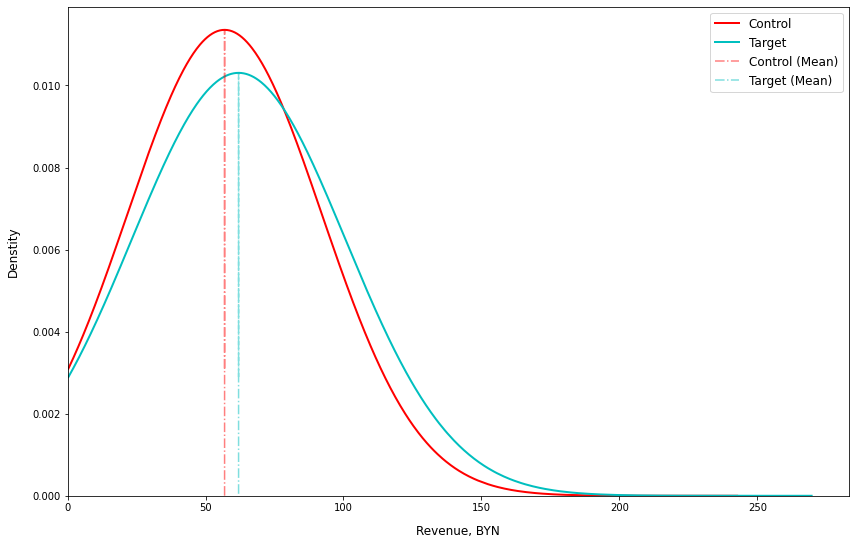

In [391]:
# график плотности распределений
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot()

x1 = revenue_control['Revenue'].sort_values().values
pdf1 = norm_cntrl.pdf(x1)
x2 = revenue_target['Revenue'].sort_values().values
pdf2 = norm_trgt.pdf(x2)
data_line_cntrl = ax.plot(x1, pdf1, 'r', label='Control', linewidth=2)
data_line_trgt = ax.plot(x2, pdf2, 'c', label='Target', linewidth=2)

x_mu_cntrl = [mu_cntrl] * len(pdf1)
x_mu_trgt = [mu_trgt] * len(pdf2)
mean_line_cntrl = ax.plot(x_mu_cntrl, pdf1, 'r-.', label='Control (Mean)', alpha=0.5)
mean_line_trgt = ax.plot(x_mu_trgt, pdf2, 'c-.', label='Target (Mean)', alpha=0.5)

plt.xlabel('Revenue, BYN', labelpad=12, fontsize=12)
plt.ylabel('Denstity', labelpad=12, fontsize=12)

plt.legend(fontsize=12)

ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)

In [390]:
# расчёт t-критерия Стьюдента и доверительной вероятности p-value 
sts.ttest_ind(revenue_control, revenue_target, equal_var=False)

Ttest_indResult(statistic=array([-6.1116146]), pvalue=array([1.03304806e-09]))

In [389]:
dy = mu_trgt - mu_cntrl # прирост
dK = ((mu_trgt / mu_cntrl) * 100) - 100 # темп прироста

Судя по графику распределений, новый баннер оказался более предпочтительным. Расчёт показыввает эффект в __~9 %__. Что насчёт значимости результата, то p-критерий позволяет утверждать об успешности при __90 %__, __95 %__ и __99 %__ (значительный вклад от относительно большой выборки). Для улучшения качества эксперимента, возможно, стоит увеличить период его проведения (чтобы собрать достаточное количество данных и тем самым уменьшить разброс значений, например).